#Grover's Algorithm

In [ ]:
!pip install qiskit
!pip install qiskit[visualization]
!pip install qiskit_aer
!pip install qiskit_ibm_runtime

In [ ]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

Grover’s algorithm is basically a quantum search through an unsorted database.  
Here, we're working with **3 qubits**, which gives us `2^3 = 8` possible states.  

We’re hiding a “needle” in this haystack — the solution is `'111'`. Let’s find it!

In [ ]:
n = 3  # Number of qubits
N = 2 ** n
solution = '111'  # Marked element (the "needle")


## The Oracle

This is the "all-knowing function" that marks our secret state.  
If the state matches the target (in our case `'111'`), it flips the sign — like a quantum post-it saying “Yo! This is the one.”

The oracle is built using quantum gates that check for our secret bit pattern.

In [ ]:
def grover_oracle(n, solution):
    qc = QuantumCircuit(n)
    for qubit, bit in enumerate(reversed(solution)):
        if bit == '0':
            qc.x(qubit)
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1)  # Multi-controlled X (Toffoli)
    qc.h(n - 1)
    for qubit, bit in enumerate(reversed(solution)):
        if bit == '0':
            qc.x(qubit)
    oracle_gate = qc.to_gate()
    oracle_gate.name = "Oracle"
    return oracle_gate

## The Diffuser

After the oracle highlights the solution, the diffuser says:  
"Okay, now amplify that solution's amplitude so it's more likely to be measured."

Mathematically, this step is basically reflecting all the state amplitudes about the average.  

In [ ]:
def grover_diffuser(n):
    qc = QuantumCircuit(n)
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1) # Multi-controlled X (Toffoli)
    qc.h(n - 1)
    qc.x(range(n))
    qc.h(range(n))
    diffuser_gate = qc.to_gate()
    diffuser_gate.name = "Diffuser"
    return diffuser_gate

## How Many Iterations Do We Need?

Turns out you don’t need to loop forever. For `N = 8` states, Grover's algorithm only needs:
  
 $$ \left\lfloor \frac{\pi}{4} \sqrt{N} \right\rfloor = 2 \text{ iterations}$$

  That’s the quadratic speedup we are looking for.

In [ ]:
iterations = int(np.floor((np.pi*1.0) / 4 * np.sqrt(N)))
print(f'Number of Grover iterations: {iterations}')


Number of Grover iterations: 2


## Assemble the Full Circuit

Now we put it all together:
- Initialize the qubits in superposition with Hadamards
- Apply Grover iterations (Oracle + Diffuser)
- Measure to collapse the state and find our “needle”

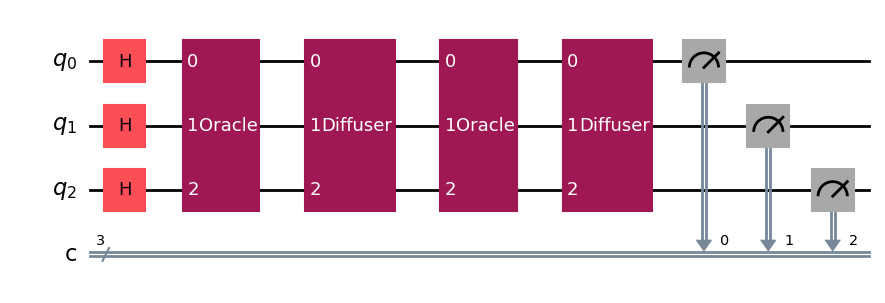

In [ ]:
qc = QuantumCircuit(n, n)

# Step 1: Apply Hadamard to all qubits to create superposition
qc.h(range(n))

# Step 2: Apply Grover iterations
oracle = grover_oracle(n, solution)
diffuser = grover_diffuser(n)

for _ in range(iterations):
    qc.append(oracle, range(n))
    qc.append(diffuser, range(n))

# Step 3: Measurement
qc.measure(range(n), range(n))

qc.draw('mpl')

{'001': 13, '000': 14, '010': 18, '110': 13, '100': 19, '101': 18, '011': 27, '111': 1926}


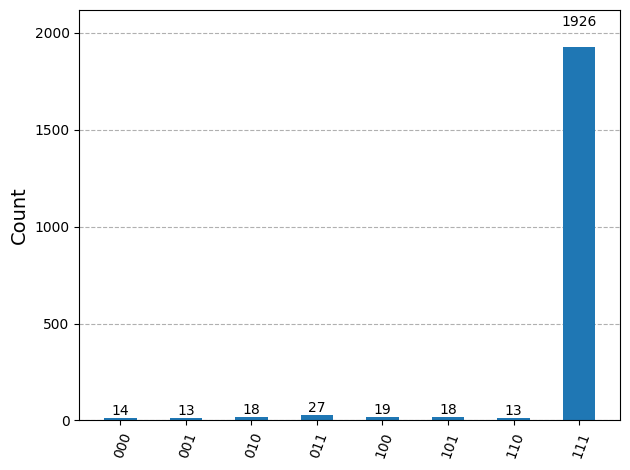

In [ ]:
from qiskit import transpile

backend = AerSimulator()
shots = 2048

# Transpile the circuit to the backend's basis gates
transpiled_qc = transpile(qc, backend)

result = backend.run(transpiled_qc, shots=shots).result()
counts = result.get_counts(transpiled_qc)
print(counts)
plot_histogram(counts)

I hope you understand what this algorithm tries to convey. Make sure you understand these thoroughly before attempting the assignment.

# Q1: Collision Detection Using Grovers Algorithm

## Problem Setup

You are provided with a system of **3 qubits**, giving you an unstructured quantum search space of:

$$
N = 2^3 = 8 \text{ possible states} \quad (|000⟩, |001⟩, ..., |111⟩)
$$

One of these states — in this case, the state `|101⟩` — represents a **"collision"**, i.e., the correct answer or the marked solution. Your task is to use Grover's algorithm to **identify this collision state** efficiently.

---

## Tasks

You are required to complete the following steps using Python and **Qiskit**:

1. **Initialize the System:**
   - Apply Hadamard gates to all qubits to prepare a uniform superposition over all 8 states.

2. **Construct the Oracle:**
   - Build a quantum oracle that recognizes the collision state `|101⟩` and flips its phase.

3. **Design the Diffusion Operator (Amplitude Amplification):**
    - Implement the diffusion step that inverts amplitudes about their average.

4. **Perform Grover Iterations:**
    - Apply the oracle and diffuser iteratively.
    - Use the theoretical formula:
      $$ r \approx \left\lfloor \frac{\pi}{4} \sqrt{N} \right\rfloor $$
     to determine how many iterations you need.

5. **Measurement and Result:**
    - Measure the final state and confirm that the algorithm amplifies the probability of observing `|101⟩`.

6. **Visualization and Analysis:**
    - Plot the **amplitude evolution** of the target state across iterations.
    - Draw the quantum circuit and final measurement histogram.

## Deliverables
  - Clear inline explanations or markdown cells summarizing.
  - What each section of code is doing.
  - The intuition behind the oracle and diffuser.
  - Why Grover’s algorithm works better than classical search.
  - At least one plot showing the growth of the target state's probability over multiple iterations.


## Bonus Challenge:

  Can you generalize your circuit to work for *any* 3-bit target state, not just `|101⟩`? Can you scale it to 4 qubits and still correctly identify a marked state?


# Q2: Solving a 3-SAT Problem Using Grover's Algorithm

## Context

The Boolean 3-SAT (3-Satisfiability) problem is a foundational example in computational complexity theory. It involves determining whether there exists an assignment of Boolean variables that satisfies a given Boolean formula in conjunctive normal form (CNF), where each clause contains exactly three literals.

3-SAT is a classic NP-complete problem. Solving it efficiently for large instances remains intractable on classical computers. However, quantum computing offers a new approach to tackle such problems using Grover’s search algorithm, which provides a quadratic speedup over classical brute-force search.

In this assignment, you will use Grover's algorithm to find a satisfying assignment for a 3-SAT problem by encoding the Boolean formula into a quantum oracle and searching for an input that satisfies it.

---

## Problem Setup

You are given a Boolean formula of the following form:

$$
(x_1 \lor \lnot x_2 \lor x_3) \land (\lnot x_1 \lor x_2 \lor x_3)$$

This formula has 3 variables: $x_1, x_2, x_3$, leading to $2^3 = 8$ possible input combinations. Your objective is to identify which of these combinations (if any) satisfy the given formula using Grover’s algorithm.

---

## Tasks

1. **Problem Encoding**
- Convert the 3-SAT Boolean formula into a classical Boolean function that returns 1 for satisfying inputs and 0 otherwise.
- Encode this Boolean function into a quantum oracle. You may use Qiskit's `PhaseOracle` or implement your own custom logic.

2. **Circuit Preparation**
- Initialize a uniform superposition over all $2^n$ basis states using Hadamard gates.
- Construct the full Grover circuit, including the oracle and the diffusion operator.

3. **Iteration Selection**
- Determine the number of Grover iterations using the formula:
     $$ r = \left\lfloor \frac{\pi}{4} \sqrt{\frac{2^n}{M}} \right\rfloor $$

  where $M$ is the number of satisfying solutions. If unknown, use $M = 1$ as an approximation for small cases.

4. **Measurement**
- Add classical registers and measure the quantum state after completing the Grover iterations.
- Simulate the circuit and identify the most probable outputs.

5. **Result Validation**
- Verify whether the measured bitstrings satisfy the original 3-SAT formula.

6. **Visualization and Documentation**
- Draw the quantum circuit using Qiskit's visualization tools.
- Plot the histogram of measurement outcomes.
- Clearly explain each section using markdown cells to document your logic, design choices, and conclusions.

---
## Bonus Challenge

- Extend your implementation to support arbitrary 3-SAT formulas with 3 or more variables.
- Analyze the impact of incorrect estimates of $M$ on the algorithm’s success rate.

---

  ## Important Notes

  Grover’s algorithm does not solve the 3-SAT problem symbolically. Instead, it performs a search over the input space and amplifies the probability of observing a correct solution. The accuracy of your oracle and your iteration count will significantly impact your final results.